##### Introduction

Target:
Predict the price of unit area for houses given their features.

Data Attributes:
- X1 transaction date
- X2 house age
- X3 distance to the nearest MRT station
- X4 number of convenience stores
- X5 latitude X6 longitude
- Y house price of unit area

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

##### Load Data

In [2]:
df = pd.read_csv('../raw_data/real_estate.csv')

# check first 5 rows
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


##### Data Understanding, Validation and Cleaning

1. Check data attributes like column names and datatypes.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


2. Check data shape for columns and rows count.

In [4]:
df.shape

(414, 8)

3. Check Duplicate values.

In [5]:
# Check for duplicate rows (all columns)
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
409    False
410    False
411    False
412    False
413    False
Length: 414, dtype: bool

In [6]:
# Check total duplicate values
df.duplicated().sum()

np.int64(0)

4. Check missing values (such as NaN or None) in a DataFrame.

In [7]:
df.isna().sum()

No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

5. Descriptive statistics of a dataset.

In [8]:
df.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


- There are no duplicate values present in dataset.
- There are no missing values in dataset.

##### Data Preprocessing

In [9]:
# Remove the No column
df.drop('No', inplace=True, axis=1)

In [10]:
# renaming all columns to coding standards (replacing space with _ )
df.rename(columns={
    "X1 transaction date": "transaction_date",
    "X2 house age": "house_age",
    "X3 distance to the nearest MRT station": "distance_to_mrt",
    "X4 number of convenience stores": "num_convenience_stores",
    "X5 latitude": "latitude",
    "X6 longitude": "longitude",
    "Y house price of unit area": "price_per_unit_area"
}, inplace=True)

df.head()

,transaction_date,house_age,distance_to_mrt,num_convenience_stores,latitude,longitude,price_per_unit_area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


Given transaction_date is not in human understandable format.

Converting this into float value to year, month, and day as separate columns.

In [11]:
def to_date(df):
    # Split transaction date into year and decimal part
    year_part = df['transaction_date'].astype(float).apply(np.floor).astype(int)
    decimal_part = df['transaction_date'] - year_part

    # Calculate month and day
    month_part = (decimal_part * 12)
    month = month_part.apply(np.floor).astype(int) + 1  # Months start at 1
    day = ((month_part - (month - 1)) * 30 + 1).astype(int)
    
    # Assign to new columns
    df['year'] = year_part
    df['month'] = month
    df['day'] = day

    df.drop(['transaction_date'], axis=1, inplace=True)
    return df

##### Exploratory Data Analysis (Basic)
- Understanding the Data before complex analysis.
- Patterns Identification.
- Data Visualization.
- Observations.

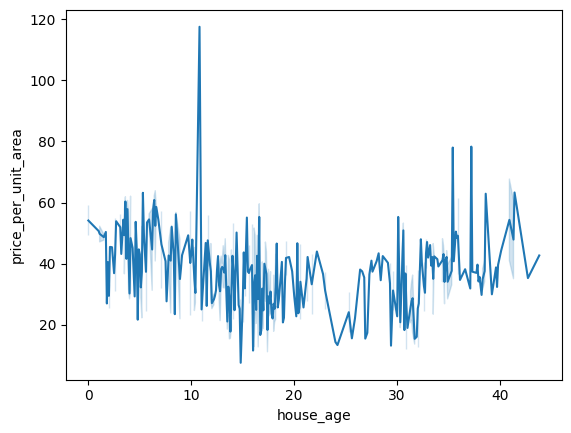

In [12]:
# house age Vs.house price of unit area
sns.lineplot(data=df, x="house_age", y="price_per_unit_area")
plt.show()

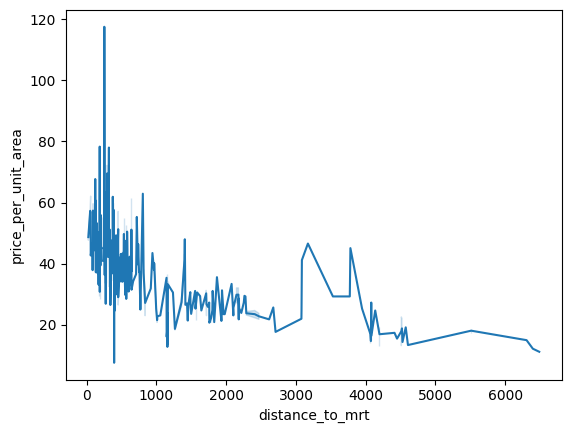

In [13]:
# distance to the nearest MRT station Vs. house price of unit area
sns.lineplot(data=df, x="distance_to_mrt", y="price_per_unit_area")
plt.show()

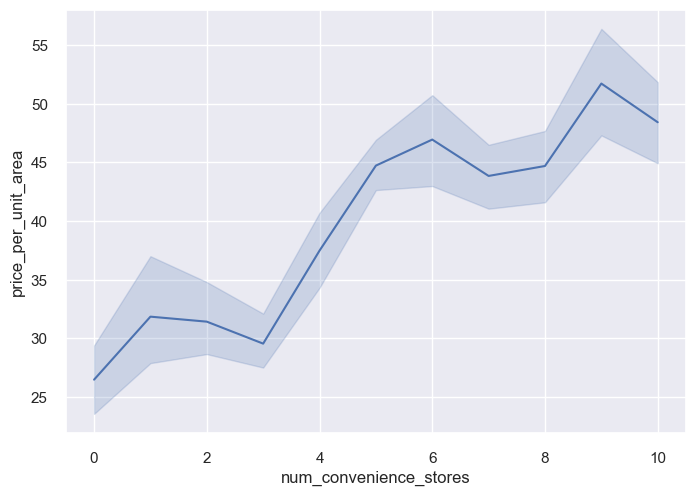

In [187]:
# number of convenience stores Vs. house price of unit area
sns.lineplot(data=df, x="num_convenience_stores", y="price_per_unit_area")
plt.show()

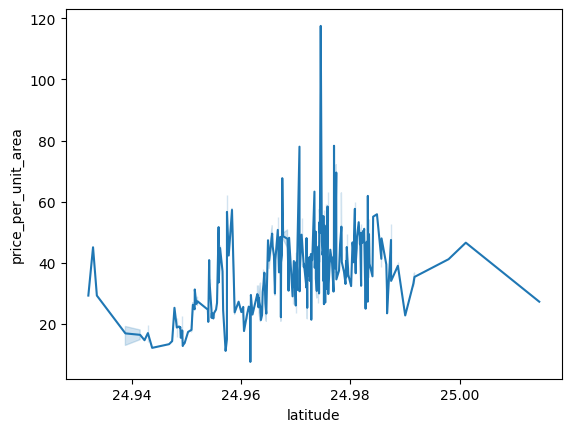

In [14]:
# latitude Vs. house price of unit area
sns.lineplot(data=df, x="latitude", y="price_per_unit_area")
plt.show()

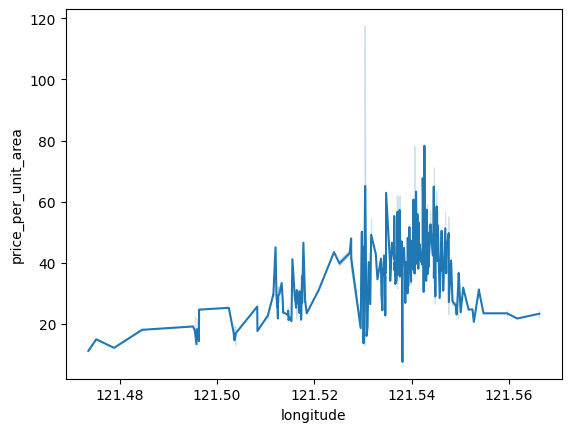

In [16]:
# longitude Vs. house price of unit area
sns.lineplot(data=df, x="longitude", y="price_per_unit_area")
plt.show()

In [17]:
df = to_date(df)
df.head()

,house_age,distance_to_mrt,num_convenience_stores,latitude,longitude,price_per_unit_area,year,month,day
0,32.0,84.87882,10,24.98298,121.54024,37.9,2012,12,1
1,19.5,306.59470,9,24.98034,121.53951,42.2,2012,12,1
2,13.3,561.98450,5,24.98746,121.54391,47.3,2013,7,30
3,13.3,561.98450,5,24.98746,121.54391,54.8,2013,7,1
4,5.0,390.56840,5,24.97937,121.54245,43.1,2012,10,30


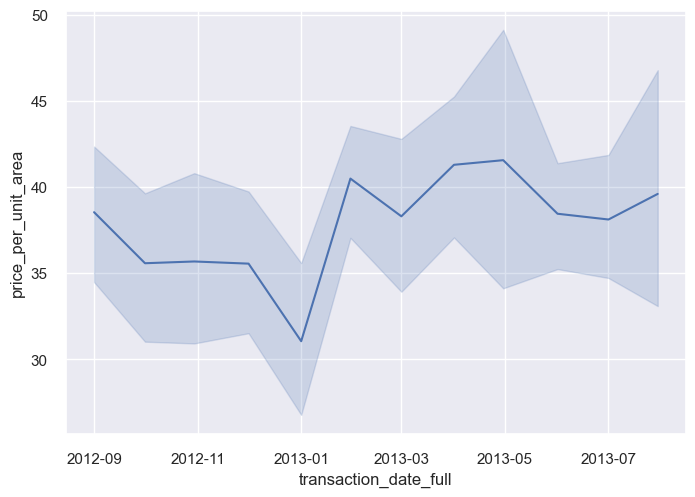

In [191]:
df["transaction_date_full"] = pd.to_datetime(df[["year", "month", "day"]])
df = df.sort_values("transaction_date_full")
sns.lineplot(data=df, x="transaction_date_full", y="price_per_unit_area")
plt.show()

Lets generate Year, Month, Day separate graphs.

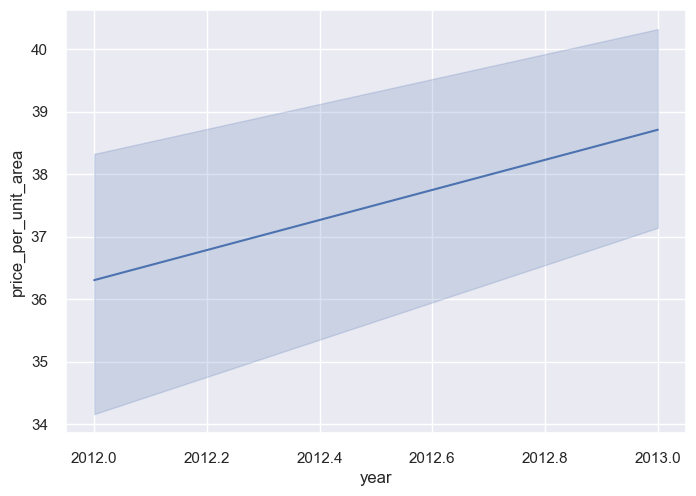

In [192]:
# Year vs house price of unit are
sns.lineplot(data=df, x="year", y="price_per_unit_area")
plt.show()

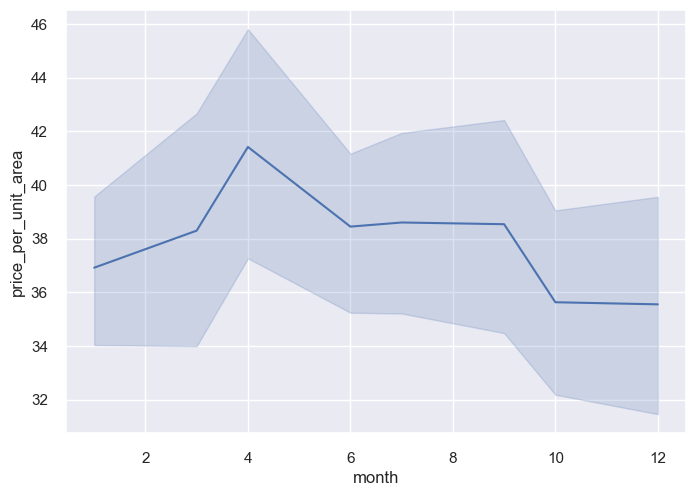

In [193]:
# Month vs house price of unit are
sns.lineplot(data=df, x="month", y="price_per_unit_area")
plt.show()

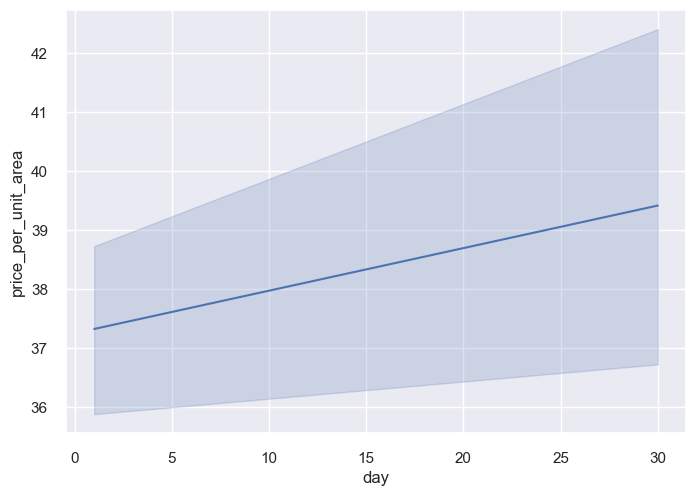

In [194]:
# Day vs house price of unit are
sns.lineplot(data=df, x="day", y="price_per_unit_area")
plt.show()

- Observations:
1. House price of unit area is proportional to the number of convenience stores.
2. Closer the house is to the nearest MRT station, the heigher the house price.
3. Based on year vs price graph: price increasing yealy.
4. Based on month vs price graph: first few months have higher value then gradually lowering price
5. Based on day vs price graph: price increasing month aswell.

<Axes: >

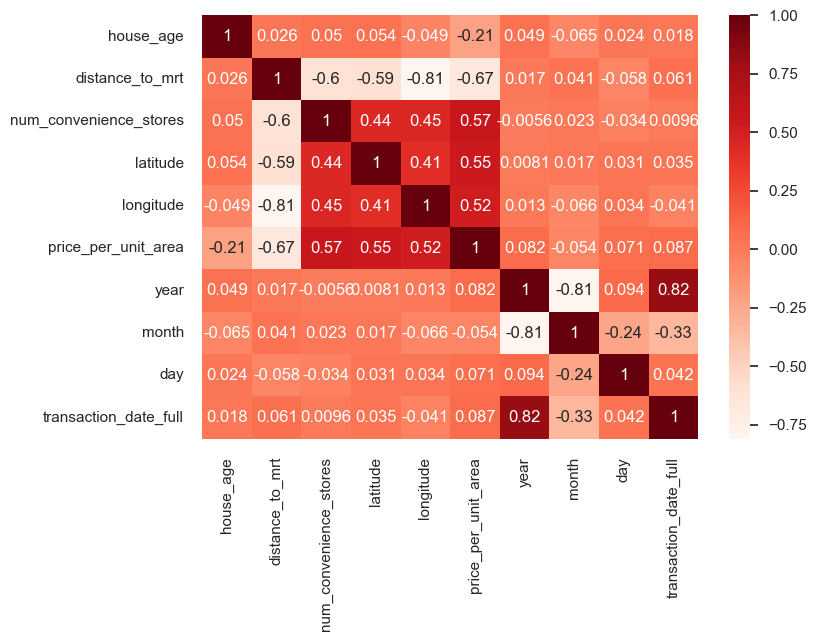

In [195]:
# Plotting correlation heatmap
corr = df.corr()
sns.heatmap(corr, cmap = 'Reds', annot= True)

In [18]:
numeric_train = df
correlation = numeric_train.corr()
correlation[['price_per_unit_area']].sort_values(['price_per_unit_area'], ascending=False)

,price_per_unit_area
price_per_unit_area,1.000000
num_convenience_stores,0.571005
latitude,0.546307
longitude,0.523287
year,0.081545
day,0.071247
month,-0.054210
house_age,-0.210567
distance_to_mrt,-0.673613


##### Splitting data into train and test

In [ ]:
data_without_price=df.drop(['price_per_unit_area'],axis=1)
house_price=df['price_per_unit_area']

df.head()

,house_age,distance_to_mrt,num_convenience_stores,latitude,longitude,price_per_unit_area,year,month,day
0,32.0,84.87882,10,24.98298,121.54024,37.9,2012,12,1
1,19.5,306.59470,9,24.98034,121.53951,42.2,2012,12,1
2,13.3,561.98450,5,24.98746,121.54391,47.3,2013,7,30
3,13.3,561.98450,5,24.98746,121.54391,54.8,2013,7,1
4,5.0,390.56840,5,24.97937,121.54245,43.1,2012,10,30


In [20]:
X_train, X_test, y_train, y_test = train_test_split(data_without_price, house_price, test_size=0.4, random_state=1)

# 0.4: 60-40 data split, 60% for training and 40% for testing

##### Model Traing and Evaluation

In [21]:
scaler = StandardScaler()

In [22]:
X_train_scaled = scaler.fit_transform(X_train)

Model Initialization: Linear Regression

In [23]:
lr_model = LinearRegression()

In [24]:
# model training
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [25]:
# check prediction result on training data
y_pred = lr_model.predict(X_train_scaled)

In [26]:
y_pred = lr_model.predict(X_train_scaled)

r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred)

print('Training:')
print('R2: ',r2)
# print('MSE: ',mse)
print('RMSE: ',rmse)
print('MAE: ',mae)

Training:
R2:  0.6104817670693099
RMSE:  7.793415147776531
MAE:  5.799806000335257


In [27]:
X_test_scaled = scaler.transform(X_test)

y_test_pred = lr_model.predict(X_test_scaled)

r2_t = r2_score(y_test, y_test_pred)
mse_t = mean_squared_error(y_test, y_test_pred)
rmse_t = np.sqrt(mse_t)
mae_t = mean_absolute_error(y_test, y_test_pred)

print('Testing:')
print('R2: ',r2_t)
# print('MSE: ',mse_t)
print('RMSE: ',rmse_t)
print('MAE: ',mae_t)

Testing:
R2:  0.53396334386882
RMSE:  10.285832468571911
MAE:  6.874657608223682


In [28]:
pd.DataFrame({
    'Training': [r2, rmse, mae],
    'Validation':  [r2_t, rmse_t, mae_t],
             },
              index=['R2', 'RMSE', 'MAE'])

,Training,Validation
R2,0.610482,0.533963
RMSE,7.793415,10.285832
MAE,5.799806,6.874658


Model Initialization: Lasso Regression

In [29]:
model_lasso = Lasso(alpha=0.1)

# To overcome over fitting problem in linear regression
# l1 regularization = lasso regression | l2 regularization = ridge regression

In [31]:
model_lasso.fit(X_train_scaled, y_train)

y_lasso_pred = model_lasso.predict(X_train_scaled)

lasso_r2_train = r2_score(y_train, y_lasso_pred)
lasso_mse_train = mean_squared_error(y_train, y_lasso_pred)
lasso_rmse_train = np.sqrt(lasso_mse_train)
lasso_mae_train = mean_absolute_error(y_train, y_lasso_pred)

print('Training:')
print('R2: ',lasso_r2_train)
# print('MSE: ',lasso_mse_train)
print('RMSE: ',lasso_rmse_train)
print('MAE: ',lasso_mae_train)

Training:
R2:  0.6094863792555039
RMSE:  7.803366570082914
MAE:  5.80790071352121


In [32]:
y_lasso_test_pred = model_lasso.predict(X_test_scaled)

lasso_r2_test = r2_score(y_test, y_lasso_test_pred)
lasso_mse_test = mean_squared_error(y_test, y_lasso_test_pred)
lasso_rmse_test = np.sqrt(lasso_mse_test)
lasso_mae_test = mean_absolute_error(y_test, y_lasso_test_pred)

print('Testing:')
print('R2: ',lasso_r2_test)
# print('MSE: ',lasso_mse_test)
print('RMSE: ',lasso_rmse_test)
print('MAE: ',lasso_mae_test)

Testing:
R2:  0.527740835358655
RMSE:  10.35427284754354
MAE:  6.912041685459585


In [33]:
pd.DataFrame({
    'Training': [lasso_r2_train, lasso_rmse_train, lasso_mae_train],
    'Validation':  [lasso_r2_test, lasso_rmse_test, lasso_mae_test],
             },
              index=['R2', 'RMSE', 'MAE'])

,Training,Validation
R2,0.609486,0.527741
RMSE,7.803367,10.354273
MAE,5.807901,6.912042


Model Initialization: Random Forest Regressor

In [34]:
from sklearn.ensemble import RandomForestRegressor

In [35]:
rf_model = RandomForestRegressor()

In [36]:
rf_model.fit(X_train_scaled, y_train)

y_c_pred = rf_model.predict(X_train_scaled)

rf_r2_train = r2_score(y_train, y_c_pred)
rf_mse_train = mean_squared_error(y_train, y_c_pred)
rf_rmse_train = np.sqrt(rf_mse_train)
rf_mae_train = mean_absolute_error(y_train, y_c_pred)

print('Training:')
print('R2: ',rf_r2_train)
# print('MSE: ',rf_mse_train)
print('RMSE: ',rf_rmse_train)
print('MAE: ',rf_mae_train)

Training:
R2:  0.9542657290742377
RMSE:  2.6704521202677935
MAE:  1.8767608870967745


In [37]:
y_rf_test_pred = rf_model.predict(X_test_scaled)

rf_r2_test = r2_score(y_test, y_rf_test_pred)
rf_mse_test = mean_squared_error(y_test, y_rf_test_pred)
rf_rmse_test = np.sqrt(rf_mse_test)
rf_mae_test = mean_absolute_error(y_test, y_rf_test_pred)

print('Testing:')
print('R2: ',rf_r2_test)
# print('MSE: ',rf_mse_test)
print('RMSE: ',rf_rmse_test)
print('MAE: ',rf_mae_test)

Testing:
R2:  0.6826952497160059
RMSE:  8.487263673920612
MAE:  5.2996942197360895


In [38]:
pd.DataFrame({
    'Training': [rf_r2_train, rf_rmse_train, rf_mae_train ],
    'Validation':  [rf_r2_test, rf_rmse_test, rf_mae_test],
             },
              index=['R2', 'RMSE', 'MAE'])

,Training,Validation
R2,0.954266,0.682695
RMSE,2.670452,8.487264
MAE,1.876761,5.299694


Model Initialization: Decision Tree Regressor

In [39]:
from sklearn.tree import DecisionTreeRegressor

In [40]:
dt_model = DecisionTreeRegressor()

In [41]:
dt_model.fit(X_train_scaled, y_train)

y_dt_pred = dt_model.predict(X_train_scaled)

dt_r2_train = r2_score(y_train, y_dt_pred)
dt_mse_train = mean_squared_error(y_train, y_dt_pred)
dt_rmse_train = np.sqrt(dt_mse_train)
dt_mae_train = mean_absolute_error(y_train, y_dt_pred)

print('Training:')
print('R2: ',dt_r2_train)
# print('MSE: ',dt_mse_train)
print('RMSE: ',dt_rmse_train)
print('MAE: ',dt_mae_train)

Training:
R2:  0.9980534245038855
RMSE:  0.5509339577539687
MAE:  0.09233870967741938


In [42]:
y_dt_test_pred = rf_model.predict(X_test_scaled)

dt_r2_test = r2_score(y_test, y_dt_test_pred)
dt_mse_test = mean_squared_error(y_test, y_dt_test_pred)
dt_rmse_test = np.sqrt(dt_mse_test)
dt_mae_test = mean_absolute_error(y_test, y_dt_test_pred)

print('Testing:')
print('R2: ',dt_r2_test)
# print('MSE: ',dt_mse_test)
print('RMSE: ',dt_rmse_test)
print('MAE: ',dt_mae_test)

Testing:
R2:  0.6826952497160059
RMSE:  8.487263673920612
MAE:  5.2996942197360895


In [43]:
pd.DataFrame({
    'Training': [dt_r2_train, dt_rmse_train, dt_mae_train ],
    'Validation':  [dt_r2_test, dt_rmse_test, dt_mae_test],
             },
              index=['R2', 'RMSE', 'MAE'])

,Training,Validation
R2,0.998053,0.682695
RMSE,0.550934,8.487264
MAE,0.092339,5.299694


R2 Score of the models

C:\Users\pushk\AppData\Local\Temp\ipykernel_9796\1936409282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = models, y = r2, palette='pastel')


Text(0, 0.5, 'R2 Score')

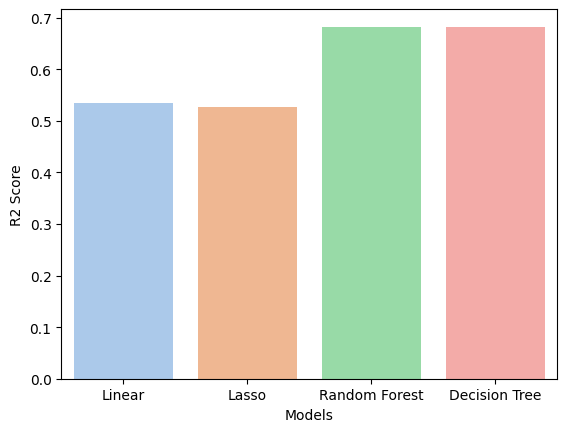

In [44]:
models = ['Linear', 'Lasso', 'Random Forest', 'Decision Tree']
r2 = [r2_t, lasso_r2_test, rf_r2_test, dt_r2_test]
ax = sns.barplot(x = models, y = r2, palette='pastel')
plt.xlabel('Models')
plt.ylabel('R2 Score')

RMSE of the models

C:\Users\pushk\AppData\Local\Temp\ipykernel_9796\1373351540.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = models, y = rmse, palette = 'pastel')


Text(0.5, 1.0, 'Comparing RMSE of Models')

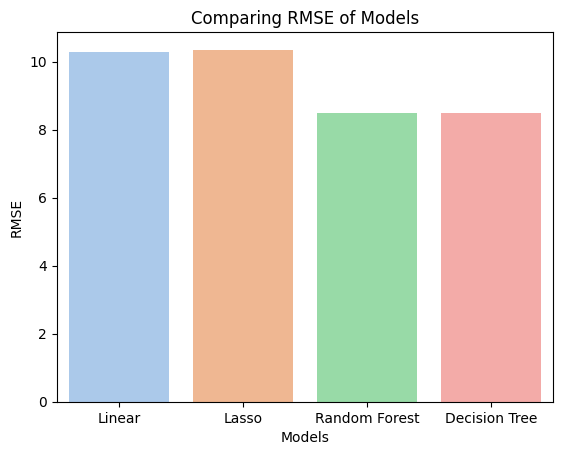

In [45]:
rmse = [rmse_t, lasso_rmse_test, rf_rmse_test, dt_rmse_test]
ax = sns.barplot(x = models, y = rmse, palette = 'pastel')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Comparing RMSE of Models')

##### We can see that the Random Forest Model performs the best.
- R2 Score  : 0.682695
- RMSE      : 8.487264

##### Save the model using pickle library

In [46]:
import pickle

In [47]:
pickle.dump(dt_model, open('../ai_model/RF_model.pkl','wb'))
pickle.dump(scaler, open('../ai_model/RF_scaler.pkl','wb'))

Successfully saved the model and scaler using pickle.

Simulate API flow.

In [51]:
with open("../ai_model/RF_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("../ai_model/RF_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# API call out

from pydantic import BaseModel

class HouseData(BaseModel):
    house_age: float
    distance_to_mrt: float
    num_convenience_stores: int
    latitude: float
    longitude: float
    year: int
    month: int
    day: int

request_data ={
    "house_age": 1.0,
    "distance_to_mrt": 500.0,
    "num_convenience_stores": 500,
    "latitude": 24.976,
    "longitude": 121.539,
    "year": 2014,
    "month": 2,
    "day": 20
}

data = HouseData(**request_data)

model_corr_df = {
    "house_age": data.house_age,
    "distance_to_mrt": data.distance_to_mrt,
    "num_convenience_stores": data.num_convenience_stores,
    "latitude": data.latitude,
    "longitude": data.longitude,
    "year": data.year,
    "month": data.month,
    "day": data.day
}

input_df = pd.DataFrame([model_corr_df])

input_scaled = scaler.transform(input_df)

prediction = model.predict(input_scaled)

print("predicted price per unit area:",prediction[0])

predicted price per unit area: 39.4
